In [24]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import sys
import os
sys.path.append(os.path.abspath('../'))

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from model_search.model_service import calculate_ratios, calculated_features
financial_dataset = pd.read_csv('../data/numerical_dataset_oversampled.csv')

## 3. Preprocessing

### 3.1 Rozkład wartości
W ramach eksploracji danych wykonano transformację logarytmiczną wybranych cech i przedstawiono ich rozkłady na wykresach KDE - wizualizacja rozkładu danych. Umożliwiło to sprawdzenie czy dane mają oczekiwane rozkłady bliskie rozkładowi normalnemu, oraz czy w danych nie ma żadnych dziwnych przesunięć.


c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Pyth

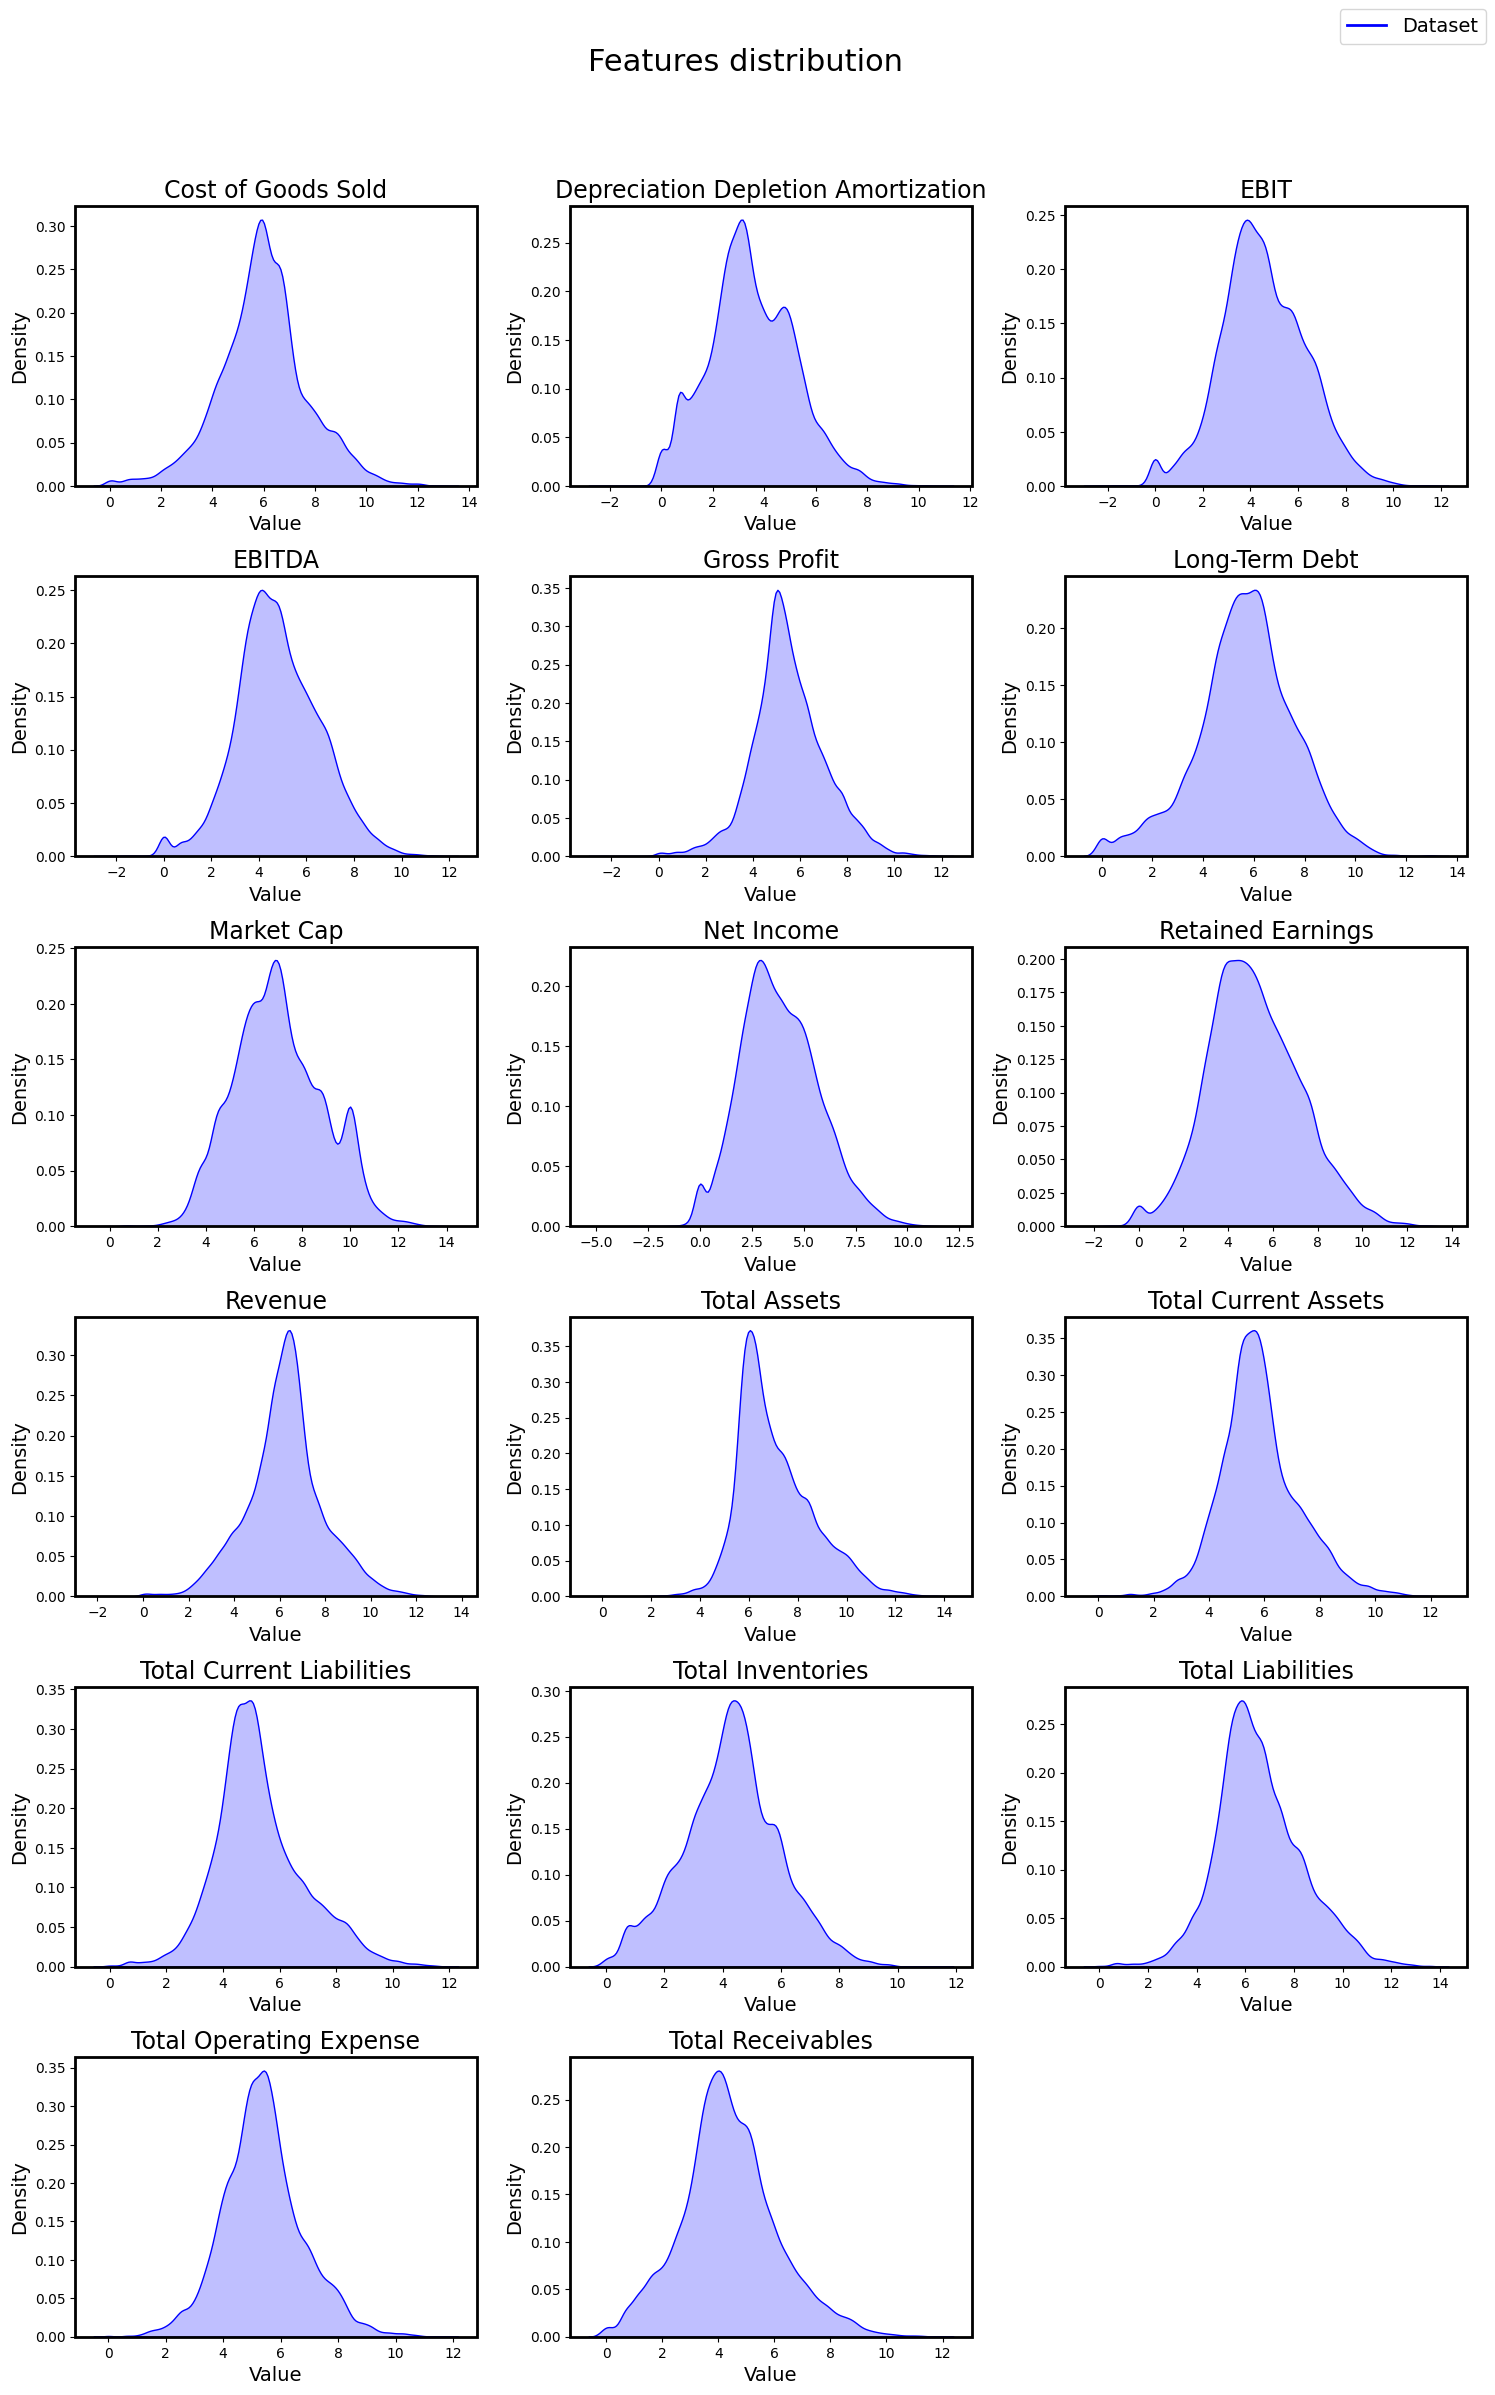

In [12]:
financial_dataset_features_dist_plot = pd.read_csv('../data/numerical_dataset_oversampled.csv')
financial_dataset_features_dist_plot.drop(['cik', 'ticker', 'Fiscal Period', 'label', 'subset'], axis=1, inplace=True)

features = financial_dataset_features_dist_plot.select_dtypes(include=['float64', 'int64']).columns

n_cols = 3
n_rows = math.ceil(len(features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
fig.suptitle('Features distribution', fontsize=22)

axes = axes.flatten()

for idx, column in enumerate(features):
    df1_log = np.log1p(financial_dataset_features_dist_plot[column])

    sns.kdeplot(df1_log, fill=True, ax=axes[idx], color='blue')
    axes[idx].set_title(f'{column}', fontsize=17)
    axes[idx].set_xlabel('Value', fontsize=14)
    axes[idx].set_ylabel('Density', fontsize=14)

    axes[idx].add_patch(Rectangle(
        (0, 0), 1, 1, transform=axes[idx].transAxes,
        fill=False, color='black', lw=2, clip_on=False))

for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

handles = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Dataset')
]

fig.legend(handles=handles, loc='upper right', ncol=1, fontsize=14)

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

### 3.3 PCA - Principal component analysis



In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_components = 2  

pca = PCA(n_components=n_components)

pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Liczba komponentów głównych')
plt.ylabel('Skumulowana wyjaśniona wariancja')
plt.title('Wariancja zachowana przez kolejne komponenty PCA')
plt.grid(True)
plt.show()

NameError: name 'X_train' is not defined

### 3.3 Czy dane wymagają normalizacji lub modyfikacji?

Tak – ze względu na dużą rozpiętość wartości (np. między firmami o małej i dużej kapitalizacji), zastosowano transformację logarytmiczną log1p dla większości cech numerycznych. Umożliwiło to:

ograniczenie wpływu dużych wartości (redukcja skali),

poprawienie symetrii rozkładu,

zwiększenie efektywności i stabilności modeli uczących się.

### 3.4 Czy zbiór danych wymaga zbalansowania klas?
Oryginalny zbiór danych jest zbalansowany, ponieważ klasy zostały wyrównane przez zastosowanie oversamplingu dla mniejszościowej klasy (firmy bankrutujące). Obecny rozkład klas przedstawia się następująco:

True (firma zbankrutuje): ~50%

False (firma nie zbankrutuje): ~50%

Dzięki temu nie ma potrzeby stosowania dodatkowych metod balansowania jak SMOTE, undersampling czy oversampling w fazie uczenia modeli.

In [13]:
financial_data_grouped = financial_dataset.groupby('cik').agg({'label': 'first', 'subset': 'first', 'ticker': 'first'})
financial_data_grouped.shape

(7214, 3)

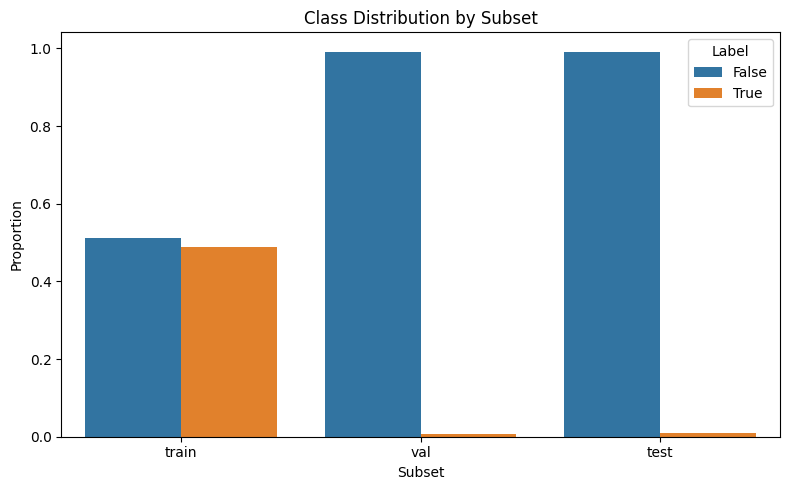

In [14]:
# Calculate normalized value counts for each subset
subsets = ['train', 'val', 'test']
data = []
for subset in subsets:
    counts = financial_data_grouped[financial_data_grouped['subset'] == subset]['label'].value_counts(normalize=True)
    for label, proportion in counts.items():
        data.append({'subset': subset, 'label': label, 'proportion': proportion})

df_plot = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
sns.barplot(data=df_plot, x='subset', y='proportion', hue='label', order=subsets, hue_order=[False, True])
plt.title('Class Distribution by Subset')
plt.ylabel('Proportion')
plt.xlabel('Subset')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

### 3.5 Wzbogacanie danych (Data Enrichment)
W zbiorze danych brakuje kilku ważnych wskaźników finansowych, jednak można je wyliczyć na podstawie już dostępnych cech.

In [15]:
financial_dataset.columns

Index(['cik', 'ticker', 'label', 'subset', 'Fiscal Period',
       'Cost of Goods Sold', 'Depreciation Depletion Amortization', 'EBIT',
       'EBITDA', 'Gross Profit', 'Long-Term Debt', 'Market Cap', 'Net Income',
       'Retained Earnings', 'Revenue', 'Total Assets', 'Total Current Assets',
       'Total Current Liabilities', 'Total Inventories', 'Total Liabilities',
       'Total Operating Expense', 'Total Receivables'],
      dtype='object')

In [30]:
enriched = calculate_ratios(financial_dataset.copy())

Sprawdzamy teraz, czy wskaźniki zostały obliczone poprawnie. Porównamy uzyskane wartości ze wskaźnikami ze strony: https://www.gurufocus.com/stock/ADNT/financials.
Porównanie zostanie przeprowadzone dla spółek o tickerach: ADNT i PAYX, ponieważ mają one stosunkowo świeże dane (do 2021 roku) i są łatwo dostępne na portalu GuruFocus.

Dopasowane wskaźniki:
- Net Profit Margin (marża zysku netto)
- EBITDA Margin (marża EBITDA)

- Gross Profit Margin (marża zysku brutto)

- Current Ratio (wskaźnik płynności bieżącej)

- Quick Ratio (wskaźnik płynności szybkiej)

- Liabilities-to-Assets Ratio (stosunek zobowiązań do aktywów)

- Asset Turnover Ratio (rotacja aktywów)

- P/E Ratio (wskaźnik cena/zysk)

- Receivables Turnover – podobny, różnica wynika z użycia „Total Receivables” zamiast „Average Accounts Receivable”

- Inventory Turnover – podobny, różnica wynika z użycia „Total Inventories” zamiast „Average Inventory”

- ROA (zwrot z aktywów) – prawie taki sam, różnica wynika z użycia „Total Assets” zamiast „Average Total Assets”

- Equity-to-Asset – prawie taki sam, różnica wynika z użycia „Total Assets” zamiast „Average Total Assets”

Po sprawdzeniu danych, okazało się, że są wskaźniki których nie da się wyliczyć z istniejących wartości lub nie są poprawne, więc je usunięto:
- Operating Profit Margin – wymaga cechy Operating Income, której nie ma w zbiorze danych. Zastąpienie jej przez EBIT byłoby błędne, ponieważ EBIT liczy się inaczej.

- Debt to Equity Ratio – = Total Liabilities / Shareholders' Equity, gdzie Shareholders' Equity = Total Assets - Total Liabilities, ale obliczenia nie są poprawne.

- Debt to Assets Ratio – nie można obliczyć, ponieważ brakuje cechy Total Debt.

- Enterprise Value (EV) – = Market Cap + Total Debt - Cash and Cash Equivalents, ale Total Debt oraz Cash and Cash Equivalents nie są dostępne.

- EV/EBITDA Ratio – nie można obliczyć z powodu braku EV.

- ROE – wymaga Shareholders' Equity, której nie ma w zbiorze.

In [ ]:
enriched[calculated_features] = enriched[calculated_features].round(2)
enriched.head()

,label,Cost of Goods Sold,Depreciation Depletion Amortization,EBIT,EBITDA,Gross Profit,Long-Term Debt,Market Cap,Net Income,Retained Earnings,...,ROA percentage,Current Ratio,Quick Ratio,Liabilities-to-Assets Ratio,Total Equity,Equity-to-Asset,Asset Turnover,Receivables Turnover,Inventory Turnover,PE Ratio
0,False,479.0,281.0,1028.0,1310.0,4004.0,1145.0,175.94,-1223.0,-10.0,...,-31.74,1.36,1.29,0.66,1291.0,0.34,1.16,7.86,9.58,-0.14
1,False,479.0,281.0,1028.0,1310.0,4004.0,1145.0,175.94,-1223.0,-10.0,...,-31.74,1.36,1.29,0.66,1291.0,0.34,1.16,7.86,9.58,-0.14
2,False,483.0,284.0,224.0,507.0,4149.0,1114.0,175.94,62.0,52.0,...,1.59,1.50,1.43,0.65,1376.0,0.35,1.19,7.88,9.47,2.84
3,False,579.0,249.0,63.0,312.0,2447.0,287.0,175.94,212.0,249.0,...,7.29,1.35,1.28,0.45,1600.0,0.55,1.04,14.91,17.55,0.83
4,False,582.0,216.0,261.0,477.0,2550.0,773.0,175.94,125.0,315.0,...,4.11,1.40,1.32,0.60,1208.0,0.40,1.03,14.84,14.20,1.41


In [33]:
enriched[calculated_features] = enriched[calculated_features].fillna(0)
print(f"Nans in the dataset: {enriched.isnull().sum().sum()}")

Nans in the dataset: 0


In [35]:
metadata_columns_count = 1
enriched_zeros_values_count_per_col = enriched.iloc[:, metadata_columns_count:][enriched == 0].count()
enriched_all_values_count = enriched.iloc[:, metadata_columns_count:].count().sum()
enriched_zeros_values_count_per_col.sort_values(ascending=False)

Depreciation Depletion Amortization    519
Net Profit Margin percentage           467
ROA percentage                         444
PE Ratio                               440
Net Income                             432
EBIT                                   341
EBITDA Margin percentage               320
EBITDA                                 285
Long-Term Debt                         269
Inventory Turnover                     215
Retained Earnings                      203
Receivables Turnover                   146
Asset Turnover                         128
Total Receivables                      128
Equity-to-Asset                        118
Cost of Goods Sold                      96
Total Inventories                       80
Quick Ratio                             69
Gross Profit Margin percentage          67
Gross Profit                            46
Liabilities-to-Assets Ratio             35
Revenue                                 35
Current Ratio                           26
Total Equit

In [36]:
print(f'Percentage of zeros in the dataset: {enriched_zeros_values_count_per_col.sum() / enriched_all_values_count * 100:.2f}%')

Percentage of zeros in the dataset: 0.46%


Zaobserwowano, że odsetek zer w zbiorze danych wzrósł o 0,05%, jednak nadal jest on bardzo niski, co nie wpływa znacząco na jakość danych.

### 3.6 Przygotowanie zbioru danych do trenowania modeli

Po wstępnej analizie i eksperymentach z kilkoma modelami okazało się, że zaproponowany podział zbioru danych na zbiory treningowy, testowy i walidacyjny prowadzi do dziwnych rezultatów — np. testowany model XGBClassifier uzyskuje zupełnie różne wartości metryki precyzji.

Zdecydowano się więc na własny podział tylko na zbiory treningowy i testowy oraz przesunięcie procesu przygotowania danych bezpośrednio przed treningiem modelu.

Usunięto kolumny metadanych, które nie są potrzebne do trenowania modelu. Pozostawiono jedynie kolumny: cik, label oraz cechy (features).
Kolumna cik jest potrzebna do grupowania danych oraz operacji spłaszczania i przywracania struktury (flattening / deflattening).

In [23]:
dataset = pd.read_csv('../data/numerical_dataset_original.csv')
dataset.drop(['cik', 'subset', 'ticker', 'Fiscal Period'], axis=1, inplace=True)
# dataset.to_csv('./data/dataset.csv', index=False)
dataset.head()

,label,Cost of Goods Sold,Depreciation Depletion Amortization,EBIT,EBITDA,Gross Profit,Long-Term Debt,Market Cap,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,False,246.5,5.5,30.0,35.5,56.2,3.9,171.0,33.6,-113.7,302.7,275.1,154.0,117.6,77.1,207.3,26.2,96.2
1,False,268.5,6.9,18.6,25.5,56.6,0.6,203.3,36.3,-77.4,325.2,307.8,185.3,123.7,77.1,201.2,38.0,110.8
2,False,312.1,8.8,20.9,29.7,60.8,0.1,185.0,12.1,-65.4,372.9,335.6,221.0,132.2,77.1,211.1,39.9,160.0
3,False,337.3,9.3,30.7,40.0,77.4,0.1,309.4,19.4,-45.9,414.6,362.9,234.3,144.2,77.1,215.4,46.6,179.7
4,False,402.3,14.7,2.2,16.9,79.0,79.2,196.4,0.0,-45.9,481.3,478.5,248.2,178.4,77.1,325.1,77.7,199.3
